In [53]:
# Libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
# Setting theme or other configurations

#Apply the default theme
sns.set_theme()

# Data
_Fraud Detection Dataset_ [Dataset Link](https://www.kaggle.com/datasets/ranjitmandal/fraud-detection-dataset-csv/data)

**Description:**

Fraudulent transactions are a growing challenge for fintech companies. This dataset captures 51,000+ transactions, each labeled as fraudulent or legitimate, based on real-world patterns.

It includes transaction details, user behavior, payment methods, and device usage, making it ideal for:

✅ Fraud detection modeling (classification)

✅ Feature engineering & anomaly detection

✅ Exploratory data analysis (EDA) & pattern recognition

Columns Overview:
Transaction Details: Amount, type, time, and payment method 💰

User Behavior: Past fraud history, account age, recent activity 📊

Device & Location: Device used, transaction location 🌍


In [55]:
df = pd.read_csv('../data/Fraud_Detection_Dataset.csv')

In [56]:
df

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50995,T33982,2339,3112.51,Bill Payment,15.0,Mobile,New York,0,7,8,Debit Card,0
50996,T31261,2152,2897.15,Online Purchase,3.0,Mobile,Miami,1,75,11,Net Banking,1
50997,T12293,3345,2204.43,POS Payment,18.0,Mobile,San Francisco,3,73,5,Credit Card,0
50998,T42287,1518,4787.17,POS Payment,19.0,Tablet,New York,2,108,14,Net Banking,0


In [57]:
# Checking for null values
df.isnull().values.any()

np.True_

In [58]:
df.isnull().sum().sum()

np.int64(12561)

In [59]:
df.isnull().sum()

Transaction_ID                         0
User_ID                                0
Transaction_Amount                  2520
Transaction_Type                       0
Time_of_Transaction                 2552
Device_Used                         2473
Location                            2547
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2469
Fraudulent                             0
dtype: int64

In [60]:
# columns with at least one missing value
cols_with_missing = df.columns[df.isnull().any()].tolist()
print(cols_with_missing)


['Transaction_Amount', 'Time_of_Transaction', 'Device_Used', 'Location', 'Payment_Method']


In [61]:
df.describe()

,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent
count,51000.000000,48480.000000,48448.000000,51000.000000,51000.000000,51000.000000,51000.000000
mean,3005.110176,2996.249784,11.488400,1.995725,60.033902,7.495588,0.049216
std,1153.121107,5043.932555,6.922954,1.415150,34.384131,4.020080,0.216320
min,1000.000000,5.030000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2007.000000,1270.552500,5.000000,1.000000,30.000000,4.000000,0.000000
50%,2996.000000,2524.100000,12.000000,2.000000,60.000000,7.000000,0.000000
75%,4006.000000,3787.240000,17.000000,3.000000,90.000000,11.000000,0.000000
max,4999.000000,49997.800000,23.000000,4.000000,119.000000,14.000000,1.000000


In [62]:
df.shape

(51000, 12)

In [63]:
df.dtypes

Transaction_ID                       object
User_ID                               int64
Transaction_Amount                  float64
Transaction_Type                     object
Time_of_Transaction                 float64
Device_Used                          object
Location                             object
Previous_Fraudulent_Transactions      int64
Account_Age                           int64
Number_of_Transactions_Last_24H       int64
Payment_Method                       object
Fraudulent                            int64
dtype: object

In [64]:
df.columns.values

array(['Transaction_ID', 'User_ID', 'Transaction_Amount',
       'Transaction_Type', 'Time_of_Transaction', 'Device_Used',
       'Location', 'Previous_Fraudulent_Transactions', 'Account_Age',
       'Number_of_Transactions_Last_24H', 'Payment_Method', 'Fraudulent'],
      dtype=object)

In [65]:
df.columns.values.tolist()

['Transaction_ID',
 'User_ID',
 'Transaction_Amount',
 'Transaction_Type',
 'Time_of_Transaction',
 'Device_Used',
 'Location',
 'Previous_Fraudulent_Transactions',
 'Account_Age',
 'Number_of_Transactions_Last_24H',
 'Payment_Method',
 'Fraudulent']

# Data cleaning

In [66]:
# Numerical columns: impute with user's median
for col in ['Transaction_Amount', 'Time_of_Transaction']:
    if col in cols_with_missing:
        df[col] = df.groupby('User_ID')[col].transform(
            lambda x: x.fillna(x.median())
        )

# Categorical columns: impute with user's mode
for col in ['Device_Used', 'Location', 'Payment_Method']:
    if col in cols_with_missing:
        df[col] = df.groupby('User_ID')[col].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
        )


In [67]:
# Drop users with only one transaction and missing values
# Since we are doing a User-Level Imputation, maybe there is a specify case where the user only
# has one transaction, so this will be a problem and personally I will drop it

users_with_one_tx = df.groupby('User_ID').filter(
    lambda x: (len(x) == 1) & (x.isnull().any().any())
)
df = df.drop(users_with_one_tx.index)


In [68]:
print("Missing values after imputation:\n", df.isnull().sum())


Missing values after imputation:
 Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64


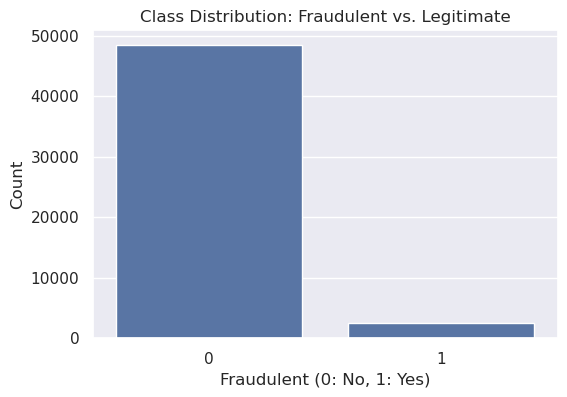

In [69]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Fraudulent', data=df)
plt.title('Class Distribution: Fraudulent vs. Legitimate')
plt.xlabel('Fraudulent (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

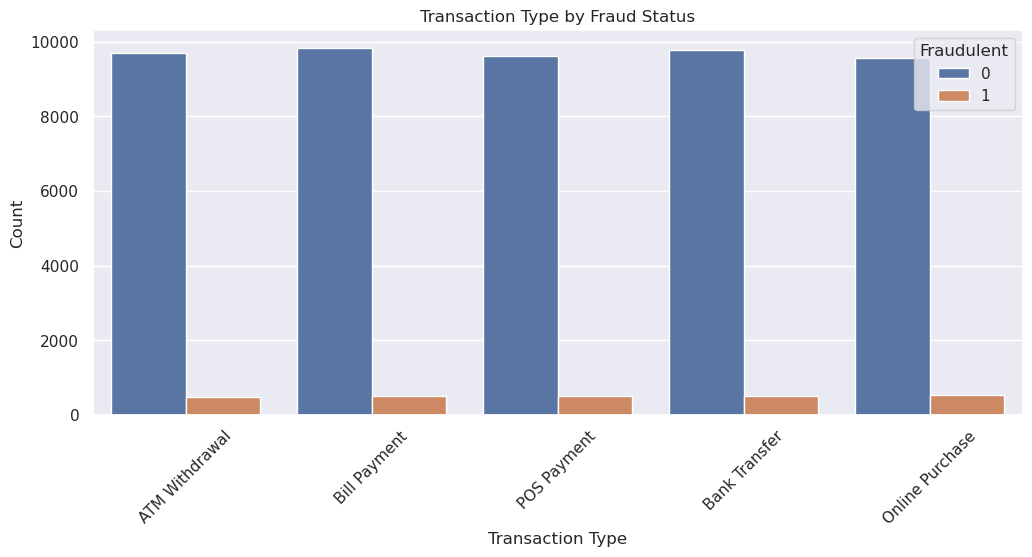

In [70]:
# Categorical Features: Transaction_Type
plt.figure(figsize=(12, 5))
sns.countplot(x='Transaction_Type', hue='Fraudulent', data=df)
plt.title('Transaction Type by Fraud Status')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

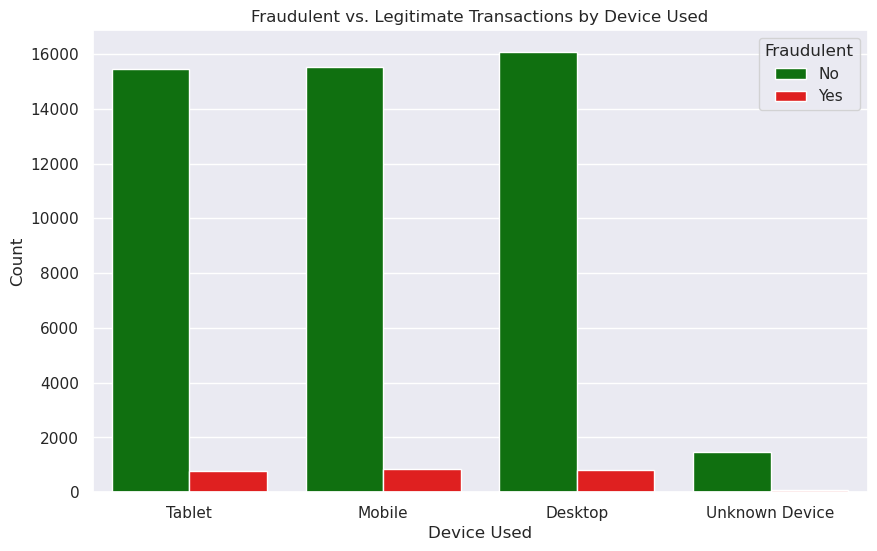

In [71]:
# Relationship between the device used and the fraud

plt.figure(figsize=(10,6))
sns.countplot(
    x='Device_Used',
    hue='Fraudulent',
    data=df,
    palette={0: "green", 1: "red"}
)
plt.title("Fraudulent vs. Legitimate Transactions by Device Used")
plt.xlabel("Device Used")
plt.ylabel("Count")
plt.legend(title="Fraudulent", labels=["No", "Yes"])
plt.show()

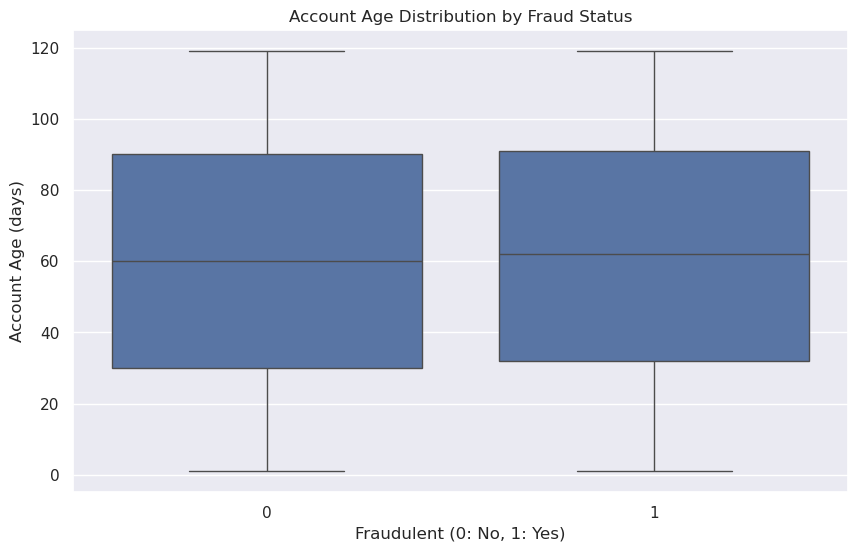

In [72]:
# Box plot of Account_Age vs. Fraudulent
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Fraudulent",
    y="Account_Age",
    data=df
)
plt.title("Account Age Distribution by Fraud Status")
plt.xlabel("Fraudulent (0: No, 1: Yes)")
plt.ylabel("Account Age (days)")
plt.show()


# Feature Engineering

In [73]:
# Device-Based Features
df['Is_Mobile'] = (df['Device_Used']=='Mobile').astype(int)
df['Is_Tablet'] = (df['Device_Used']=='Tablet').astype(int)
df['Is_Desktop'] = (df['Device_Used']=='Desktop').astype(int)

In [74]:
# Adding a Binary flag for new accounts, sometimes could be related to fraud transactions
# We need define the number of day to consider a account new, let say 30 days
df['Is_New_Account'] = (df['Account_Age'] < 30).astype(int)


In [75]:
# Combine Is_New_Account and Is_Mobile
df['New_Account_And_Tablet'] = (df['Is_New_Account'] & df['Is_Mobile']).astype(int)

In [76]:
df['Transaction_Hour'] = df['Time_of_Transaction'].apply(lambda x: int(x % 24))


In [77]:
# Avg_Transaction_Amount_Past_24H (User Behavior Feature)
df['Avg_Transaction_Amount_Past_24H'] = df.groupby('User_ID')['Transaction_Amount'].transform(
    lambda x: x.rolling(window=24, min_periods=1).mean().shift(1)
)

# Amount_Ratio_To_Avg (Amount-Based Feature)
# User's average transaction amount
user_avg_amount = df.groupby('User_ID')['Transaction_Amount'].mean().reset_index()
user_avg_amount.rename(columns={'Transaction_Amount': 'User_Avg_Amount'}, inplace=True)
df = df.merge(user_avg_amount, on='User_ID', how='left')

# Ratio
df['Amount_Ratio_To_Avg'] = df['Transaction_Amount'] / df['User_Avg_Amount']

## Above will create NaN so let fill up with 0
df['Avg_Transaction_Amount_Past_24H'] = df['Avg_Transaction_Amount_Past_24H'].fillna(0)


# Show the first few rows with new features
df[[
    'Transaction_Amount', 'Time_of_Transaction', 'Transaction_Hour',
    'Avg_Transaction_Amount_Past_24H', 'User_Avg_Amount', 'Amount_Ratio_To_Avg'
]].head()

,Transaction_Amount,Time_of_Transaction,Transaction_Hour,Avg_Transaction_Amount_Past_24H,User_Avg_Amount,Amount_Ratio_To_Avg
0,1292.76,16.0,16,0.0,2063.072222,0.626619
1,1554.58,13.0,13,0.0,3072.946667,0.505892
2,2395.02,13.5,13,0.0,2837.284000,0.844124
3,100.10,15.0,15,0.0,2659.681000,0.037636
4,1490.50,19.0,19,0.0,2537.149000,0.587470


In [78]:
# Check for any remaining NaN values
print(df[['Transaction_Hour', 'Avg_Transaction_Amount_Past_24H', 'Amount_Ratio_To_Avg']].isnull().sum())

# Check the distribution of the new features
print(df[['Transaction_Hour', 'Avg_Transaction_Amount_Past_24H', 'Amount_Ratio_To_Avg']].describe())


Transaction_Hour                   0
Avg_Transaction_Amount_Past_24H    0
Amount_Ratio_To_Avg                0
dtype: int64
       Transaction_Hour  Avg_Transaction_Amount_Past_24H  Amount_Ratio_To_Avg
count      51000.000000                     51000.000000         51000.000000
mean          11.481627                      2761.553611             1.000000
std            6.787654                      2589.060434             0.906636
min            0.000000                         0.000000             0.000795
25%            6.000000                      1950.162406             0.464795
50%           12.000000                      2473.260000             0.914155
75%           17.000000                      2990.157727             1.365569
max           23.000000                     49997.800000            12.939758


In [79]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(df, columns=['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method'])


In [80]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data_encoded.drop(columns=['Fraudulent', 'Transaction_ID'])  # Exclude non-numeric or irrelevant columns
y = data_encoded['Fraudulent']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Let's handle the imbalance problem, because if we see the initial steps in the EDA we see that this dataset is imbalance there are many legit transactions and few fraudulent
- confirm in 1.2. Problem statement regarding data sets
- https://imbalanced-learn.org/stable/introduction.html#problem-statement-regarding-imbalanced-data-sets


In [81]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.95      0.84      0.89      9688
           1       0.05      0.16      0.08       512

    accuracy                           0.81     10200
   macro avg       0.50      0.50      0.48     10200
weighted avg       0.90      0.81      0.85     10200



/home/cristian/anaconda3/envs/anaconda-banking/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cristian/anaconda3/envs/anaconda-banking/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      9688
           1       0.06      0.11      0.07       512

    accuracy                           0.86     10200
   macro avg       0.50      0.51      0.50     10200
weighted avg       0.91      0.86      0.88     10200

AUC-ROC: 0.4950569083531173


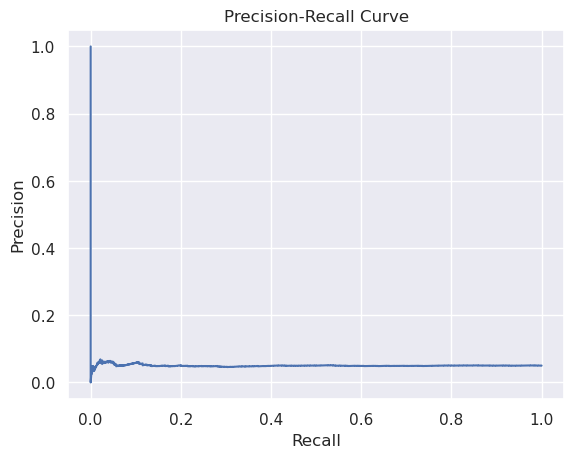

In [83]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Train XGBoost with class weights
model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=5,
    random_state=42,
    eval_metric='aucpr'
)
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for AUC-ROC

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [84]:
import pickle

# Save the trained model
pickle.dump(model, open('../models/fraud_model.pkl', 'wb'))


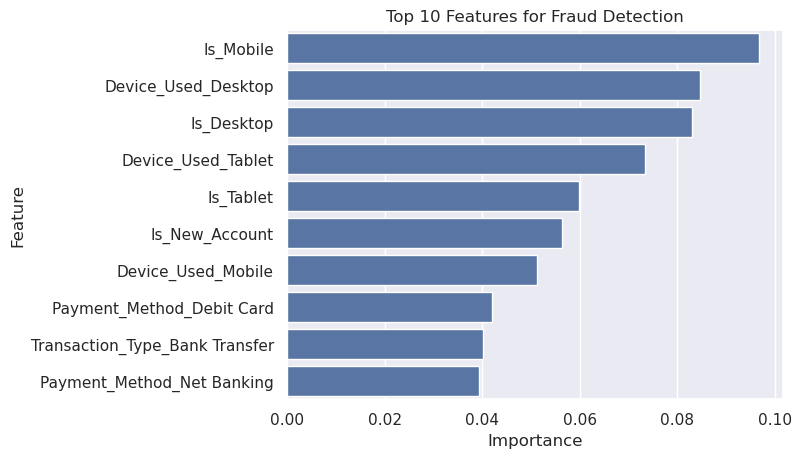

In [85]:
# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for Fraud Detection')
plt.show()


In [86]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on legitimate transactions
legit_transactions = X_train[y_train == 0]
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(legit_transactions)

# Predict anomalies on the test set
# Use only the original features
X_test_original = X_test.copy()

# Calculate anomaly scores and predictions
anomaly_scores = iso_forest.decision_function(X_test_original)
is_anomaly = iso_forest.predict(X_test_original) == -1  # -1 means anomaly

# Add results to a copy of X_test_original to avoid modifying the original data
X_test_results = X_test_original.copy()
X_test_results['Anomaly_Score'] = anomaly_scores
X_test_results['Is_Anomaly'] = is_anomaly

# Compare with actual fraud labels
print("Anomaly Detection Results:")
print(pd.crosstab(y_test, X_test_results['Is_Anomaly']))



Anomaly Detection Results:
Is_Anomaly  False  True 
Fraudulent              
0            9198    490
1             486     26


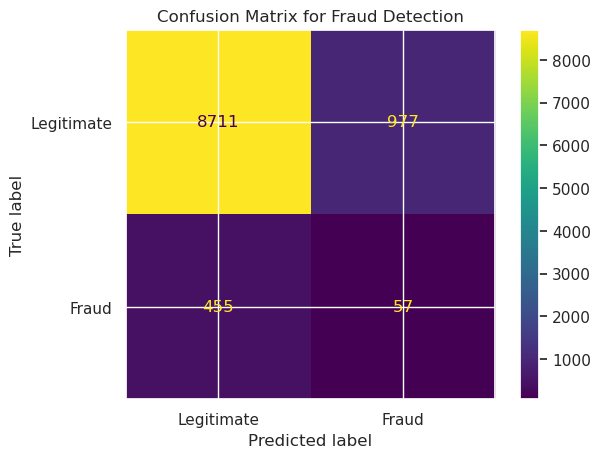

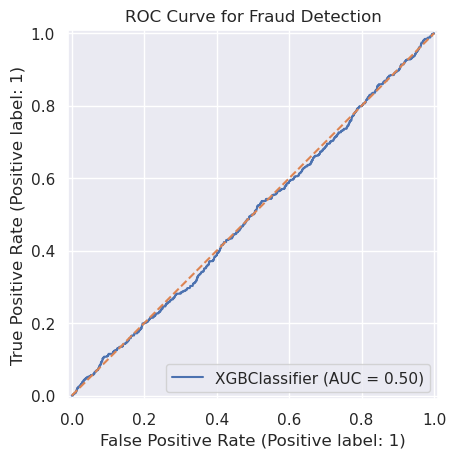

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix for Fraud Detection')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('ROC Curve for Fraud Detection')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for random guessing
plt.show()
